In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

In [3]:
# 初始化Spark会话
spark = SparkSession.builder.appName("ExploreEducationData").getOrCreate()

# 数据文件路径
path_prefix = "data/"  # 需要根据实际情况调整
datasets = {
    "course_chapter": "course_chapter.csv",
    "course_task": "course_task.csv",
    "classroom_member": "classroom_member.csv",
    "classroom_courses": "classroom_courses.csv",
    "log": "log.csv",
    "user_learn_statistics_total": "user_learn_statistics_total.csv",
    "activity_learn_log": "activity_learn_log.csv",
    "testpaper": "testpaper.csv",
    "testpaper_result": "testpaper_result.csv",
    # "教学视频" 对应的数据可能不适合直接以表格形式读取
}

# 读取所有数据表
dataframes = {}
for name, file in datasets.items():
    df = spark.read.csv(f"{path_prefix}{file}", header=True, inferSchema=True)
    dataframes[name] = df

# 例：查看每个表的基本信息
for name, df in dataframes.items():
    print(f"---{name}---")
    df.show(5)  # 显示前5行
    df.printSchema()  # 打印表结构
    print(f"Total rows: {df.count()}\n")  # 显示总行数


---course_chapter---
+---+--------+-------+------+---+------------+-----------+-----------+------+---------+----------+---------------+-------------------+----------------+----------------+---------------+----------------+
| id|courseId|   type|number|seq|       title|createdTime|updatedTime|copyId|   status|isOptional|migrateLessonId|migrateCopyCourseId|migrateRefTaskId|mgrateCopyTaskId|migrate_task_id|published_number|
+---+--------+-------+------+---+------------+-----------+-----------+------+---------+----------+---------------+-------------------+----------------+----------------+---------------+----------------+
| 13|       3| lesson|     2|  4|        引言| 1536659838| 1560909864|     0|published|         0|              0|                  0|               0|               0|              0|               2|
| 14|       3|chapter|     1|  3|机器学习绪论| 1536659876| 1560909861|     0|published|         0|              0|                  0|               0|               0|           

In [4]:
# 确保所有表都被创建为Spark DataFrame，并创建为临时视图
for name, df in dataframes.items():
    df.createOrReplaceTempView(name)

# 执行SQL查询来聚合数据
aggregated_data_query = """
SELECT 
    u.userId,
    SUM(u.learnedSeconds) as totalLearnedSeconds,
    SUM(u.finishedTaskNum) as totalFinishedTasks,
    AVG(t.score) as averageScore
FROM 
    user_learn_statistics_total u
LEFT JOIN 
    testpaper_result t ON u.userId = t.userId
GROUP BY 
    u.userId
"""
aggregated_data_df = spark.sql(aggregated_data_query)

# 将聚合结果转换为Pandas DataFrame以进行可视化
aggregated_data_pd = aggregated_data_df.toPandas()

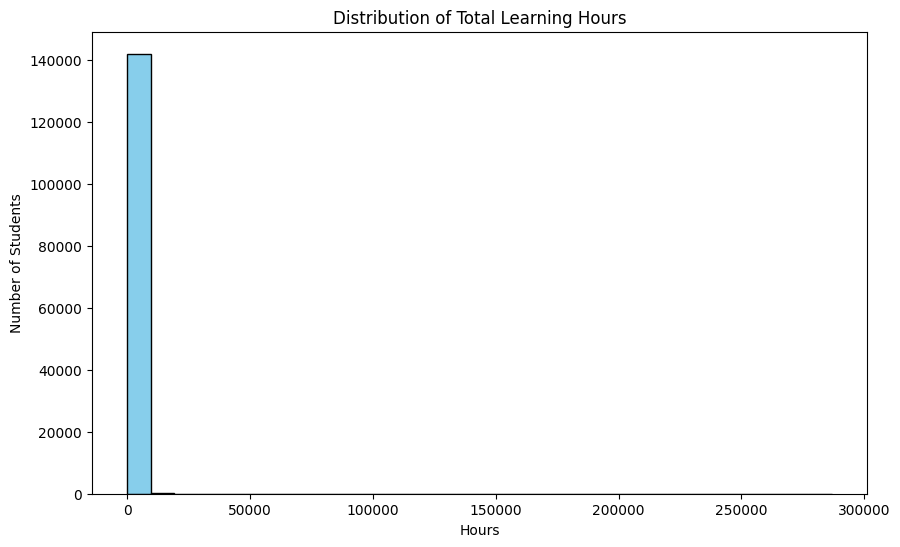

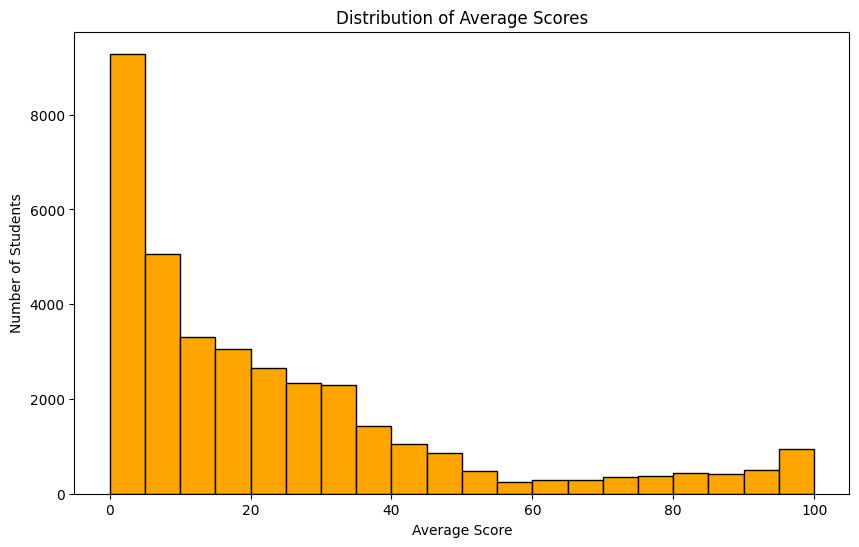

In [5]:
# 可视化学习时间的分布
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(aggregated_data_pd['totalLearnedSeconds'] / 3600, bins=30, color='skyblue', edgecolor='black')  # 将秒转换为小时
plt.title('Distribution of Total Learning Hours')
plt.xlabel('Hours')
plt.ylabel('Number of Students')
plt.show()

# 可视化成绩分布
plt.figure(figsize=(10, 6))
plt.hist(aggregated_data_pd['averageScore'].dropna(), bins=20, color='orange', edgecolor='black')
plt.title('Distribution of Average Scores')
plt.xlabel('Average Score')
plt.ylabel('Number of Students')
plt.show()


In [8]:
# 创建临时视图，如果尚未创建
dataframes['user_learn_statistics_total'].createOrReplaceTempView("user_learn_statistics_total")

# 执行SQL查询以聚合学生的总学习时间
student_learning_time_query = """
SELECT 
    userId,
    SUM(learnedSeconds) AS totalLearnedSeconds,
    ROUND(SUM(learnedSeconds) / 3600.0, 2) AS totalLearnedHours  -- 转换为小时，并保留两位小数
FROM 
    user_learn_statistics_total
GROUP BY 
    userId
ORDER BY 
    totalLearnedHours DESC  -- 可以根据需求选择是否排序
"""

# 执行查询
student_learning_time_df = spark.sql(student_learning_time_query)

# 显示查询结果
student_learning_time_df.show()


+------+-------------------+-----------------+
|userId|totalLearnedSeconds|totalLearnedHours|
+------+-------------------+-----------------+
| 76619|           12778285|          3549.52|
| 45231|            8113482|          2253.75|
| 65143|            6867352|          1907.60|
| 62585|            5828740|          1619.09|
| 63354|            4580668|          1272.41|
| 49318|            4198095|          1166.14|
| 41466|            4130970|          1147.49|
| 41187|            4125329|          1145.92|
| 82424|            4070003|          1130.56|
| 16941|            3999224|          1110.90|
| 27590|            3457340|           960.37|
| 15485|            3293529|           914.87|
| 86673|            3263641|           906.57|
| 15821|            3235802|           898.83|
| 19698|            3171766|           881.05|
| 74901|            3130620|           869.62|
| 11401|            3108567|           863.49|
| 19994|            3102061|           861.68|
| 70342|     

In [30]:
# 创建临时视图，如果尚未创建
dataframes['user_learn_statistics_total'].createOrReplaceTempView("user_learn_statistics_total")

# 执行SQL查询以聚合学生的总学习时间（以小时为单位）
student_learning_time_query = """
SELECT 
    userId,
    SUM(learnedSeconds) / 3600.0 AS totalLearnedHours  -- 转换为小时
FROM 
    user_learn_statistics_total
GROUP BY 
    userId
ORDER BY 
    userId
"""

# 执行查询
student_learning_time_df = spark.sql(student_learning_time_query)

# 显示查询结果
student_learning_time_df.show()


+------+-----------------+
|userId|totalLearnedHours|
+------+-----------------+
|     1|         0.000000|
|     3|         6.492500|
|     4|         6.525556|
|     5|       135.337778|
|     6|         0.016667|
|     7|        80.967500|
|     9|         0.000000|
|    10|         0.548056|
|    11|         0.078333|
|    12|        19.119444|
|    13|       154.190556|
|    14|         2.212500|
|    15|        19.117500|
|    16|       251.561389|
|    17|        89.749167|
|    18|        40.111111|
|    19|         0.006389|
|    20|        59.713333|
|    21|       139.586389|
|    22|        85.662778|
+------+-----------------+


In [31]:
# 转换为Pandas DataFrame
student_learning_time_pd = student_learning_time_df.toPandas()

# 显示Pandas DataFrame
print(student_learning_time_pd.head())


   userId totalLearnedHours
0       1          0.000000
1       3          6.492500
2       4          6.525556
3       5        135.337778
4       6          0.016667


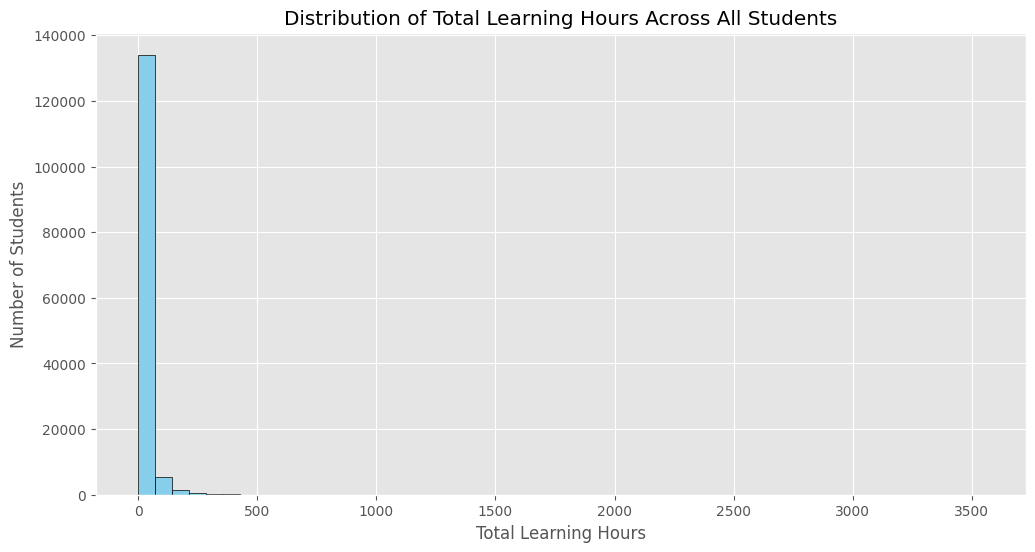

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(student_learning_time_pd['totalLearnedHours'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Learning Hours Across All Students')
plt.xlabel('Total Learning Hours')
plt.ylabel('Number of Students')
plt.grid(True)
plt.show()


In [33]:
# 指定CSV文件的保存路径
output_csv_path = "D:/FAOS/Python/Pyspark/data/result/student_learning_hours.csv"  # 需要替换为实际路径

# 保存DataFrame到CSV文件
student_learning_time_pd.to_csv(output_csv_path, index=True)  # 设置index=False以避免在CSV中保存行索引


In [34]:
import pandas as pd

# 读取CSV文件
csv_path = 'D:/FAOS/Python/Pyspark/data/result/student_learning_hours.csv'  # 更新为你的CSV文件路径
data = pd.read_csv(csv_path)

# 检查前几行数据
print(data.head())


   Unnamed: 0  userId  totalLearnedHours
0           0       1           0.000000
1           1       3           6.492500
2           2       4           6.525556
3           3       5         135.337778
4           4       6           0.016667


In [38]:
# 以每5小时为一个桶进行分组
bins = range(0, int(data['totalLearnedHours'].max() + 100), 100)  # 根据数据最大值定义bins范围
labels = [f'{i}' for i in bins[:-1]]
data['HourRange'] = pd.cut(data['totalLearnedHours'], bins=bins, labels=labels, right=False)

# 聚合数据
binned_data = data.groupby('HourRange').size().reset_index(name='Count')

# 检查聚类结果
print(binned_data)


   HourRange   Count
0          0  137303
1        100    3725
2        200     788
3        300     244
4        400     101
5        500      43
6        600      18
7        700      10
8        800       6
9        900       3
10      1000       0
11      1100       5
12      1200       1
13      1300       0
14      1400       0
15      1500       0
16      1600       1
17      1700       0
18      1800       0
19      1900       1
20      2000       0
21      2100       0
22      2200       1
23      2300       0
24      2400       0
25      2500       0
26      2600       0
27      2700       0
28      2800       0
29      2900       0
30      3000       0
31      3100       0
32      3200       0
33      3300       0
34      3400       0
35      3500       1


In [40]:
# 指定CSV文件的保存路径
output_csv_path = "D:/FAOS/Python/Pyspark/data/result/student_learning_scatter.csv"  # 需要替换为实际路径

# 保存DataFrame到CSV文件
binned_data.to_csv(output_csv_path, index=True)  # 设置index=False以避免在CSV中保存行索引

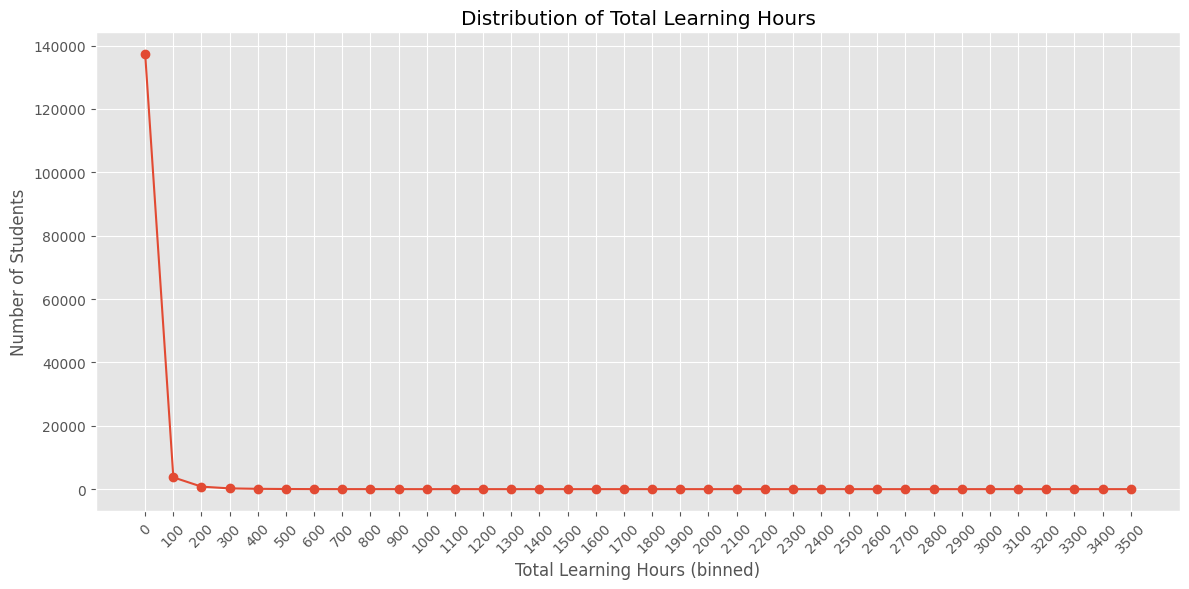

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(binned_data['HourRange'], binned_data['Count'], marker='o')
plt.title('Distribution of Total Learning Hours')
plt.xlabel('Total Learning Hours (binned)')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
